In [408]:
# Import statements 
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import sklearn
from sklearn import metrics
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns

In [409]:
# Read in matlab data and extract the Raman spectra data
result = loadmat('pone.0197134.s005.mat')
Xfilt = result['Xfilt']
nested = Xfilt[0][0]
data = nested[0]

# Isolate certaun features to visualize
ID = pd.DataFrame(nested[1],columns=["Person No", "Analysis Day"])
numdate = pd.DataFrame(nested[2],columns=["num date"])
setting = pd.DataFrame(nested[3],columns=["setting"])
skin = pd.DataFrame(nested[4],columns=["skin depth"])
axis = nested[6] 
x_data = pd.DataFrame(data * (1/axis))

# Create y_data vector of blood glucose levels
yref = pd.DataFrame(nested[5],columns=["Blood Glucose Level"])
y_data = pd.DataFrame(yref, dtype='float')

# Isolate the feautures we want to use for our machine learning algorithms
df = pd.concat([setting, skin, x_data], axis=1, join='inner')


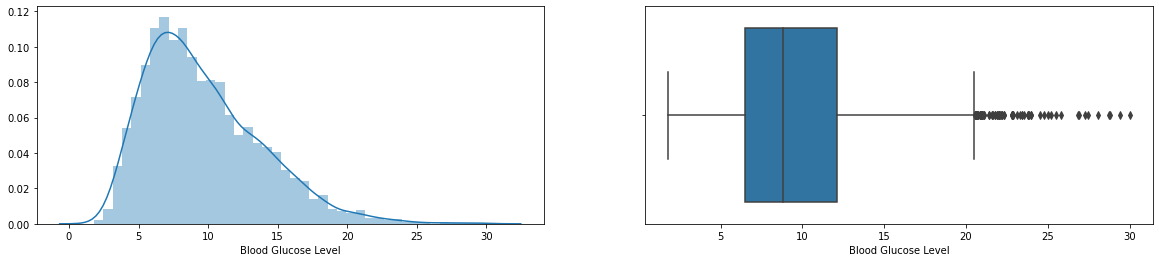

In [423]:
# Display distribution of blood glucose levels in the data using two different plots to see outliers
fig = plt.figure(figsize=(20,4))
fig.add_subplot(1,2,1)
sns.distplot(dfall['Blood Glucose Level'])
fig.add_subplot(1,2,2)
sns.boxplot(dfall['Blood Glucose Level'])

In [410]:
# Standardize the data to have a mean of 0 and variance of 1
sc = StandardScaler()
scaled_x_data = sc.fit_transform(df) 

In [411]:
# Perform PCA to choose the minimum number of principal components such that 95% of the variance is retained
pca = PCA(.95)
principalComponents = pca.fit_transform(scaled_x_data)

In [420]:
# Make a copy of y_Data as to not alter the original data column
y_data_01 = y_data.copy()

# Exract the true label column where to be 0 when blood glucose level is between 4-7, and 1 outside this range
y_data_01["Blood Glucose Level"] = np.where((y_data["Blood Glucose Level"] <= 7) & (y_data["Blood Glucose Level"] >= 4), 0, 1)

# Create the training and testing sets 
x_train, x_test, y_train, y_test = train_test_split(scaled_x_data, y_data_01, test_size=0.2, train_size = 0.8)

In [421]:
# Initialize a mulilayer perceptron classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 30,),
                    activation='relu',
                    solver='adam',
                    batch_size=32,
                    learning_rate = 'adaptive',
                    learning_rate_init=0.0001,
                    max_iter=500).fit(x_train, y_train)

# Use MLP classifier to predict on our test set                   
y_pred = mlp.predict(x_test)

/Users/lizzy/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


              precision    recall  f1-score   support

           0       0.46      0.09      0.15       234
           1       0.74      0.96      0.84       635

    accuracy                           0.73       869
   macro avg       0.60      0.53      0.49       869
weighted avg       0.66      0.73      0.65       869

Training set score: 0.731279
Test set score: 0.726122


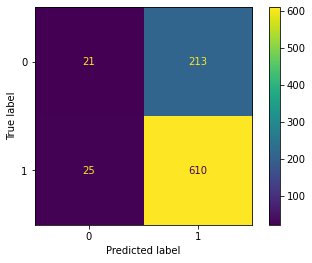

In [422]:
# Evaluate the model
print(classification_report(y_test, y_pred))
print("Training set score: %f" % mlp.score(x_train, y_train))
print("Test set score: %f" % mlp.score(x_test, y_test))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()